# 자동차 연비 예측하기: 회귀

*회귀*(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와는 달리 *분류*(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다(예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것).

이 노트북은 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만듭니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 이 정보에는 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함됩니다.

이 예제는 `tf.keras` API를 사용합니다. 자세한 내용은 [케라스 가이드](https://www.tensorflow.org/guide/keras)를 참고하세요.

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
# !pip install -q seaborn
%pip install tqdm ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt        # MATLAB 호환

# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac (AppleGothic 또는 AppleSDGothicNeo)
# plt.rcParams['font.family'] = 'NanumGothic' # Linux (NanumGothic 또는 다른 설치된 한글 폰트)

plt.rcParams['axes.unicode_minus'] = False #glypy 8722: Axes에 - 표시 안되는 것
# plt.title('한글 타이틀...')

In [4]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #0: 모든 메시지, 1: 정보 숨김, 2: 경고 숨김, 3: 에러만 출력)
import multiprocessing
import tensorflow as tf
import keras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU 비활성화 (CPU 모드 강제)
num_cores = multiprocessing.cpu_count()

tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

from sklearn.model_selection import train_test_split

## Auto MPG 데이터셋

이 데이터셋은 [UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 다운로드할 수 있습니다.
 - https://archive.ics.uci.edu/dataset/9/auto+mpg

먼저 데이터셋을 다운로드합니다.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/ihanjo/.keras/datasets/auto-mpg.data'

In [6]:
!cat /root/.keras/datasets/auto-mpg.data

cat: /root/.keras/datasets/auto-mpg.data: No such file or directory


판다스를 사용하여 데이터를 읽습니다.

```
1) mpg: 연비
2) cylinders: 실린더 개수
3) displacement: 배기량
4) horsepower: 마력
5) weight: 무게
6) acceleration: 엔진이 초당 얻을 수 있는 가속력
7) model year: 출시 년도
8) origin: 제조 장소(1: 미국 USA, 2: 유럽 EU, 3: 일본 JPN)
9) car name: 자동차 이름근처 자동차 대리점
```

In [7]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [9]:
dataset['Horsepower'].min(), dataset['Horsepower'].max()

(46.0, 230.0)

In [10]:
dataset['Horsepower'].isna().sum()

6

In [11]:
dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


## EDA


엔진 크기에 따른 주행 마일수에 대한 관계, 영향력을 살펴보기 위해서 산점도 그래프를 그려보자.

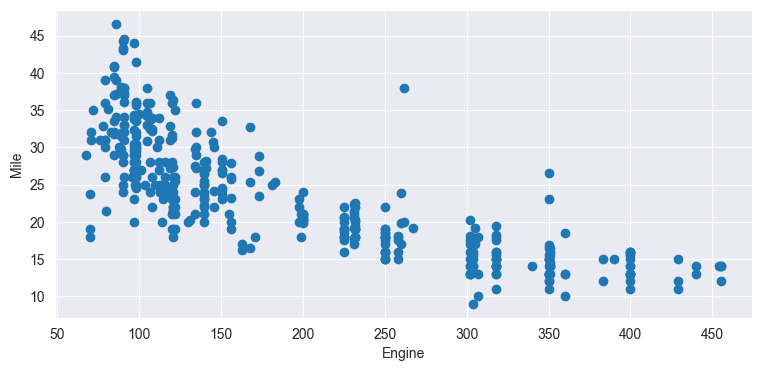

In [12]:
plt.figure(figsize=(9,4))

plt.plot(
    dataset['Displacement'],
    dataset['MPG'],
    marker='o',
    linestyle='None'
)

plt.xlabel('Engine')
plt.ylabel('Mile')
plt.grid(True)
plt.show()

엔진 크기가 작을 수록 주행 마일수가 긴것을 확인할 수 있다.

### 데이터 클린징

결측치를 처리합니다

In [13]:
median_horsepower = dataset['Horsepower'].median()
dataset['Horsepower'] = dataset['Horsepower'].fillna(median_horsepower)

In [14]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

### 단변량 분석



In [15]:
raw_dataset.columns[:-1]

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year'],
      dtype='object')

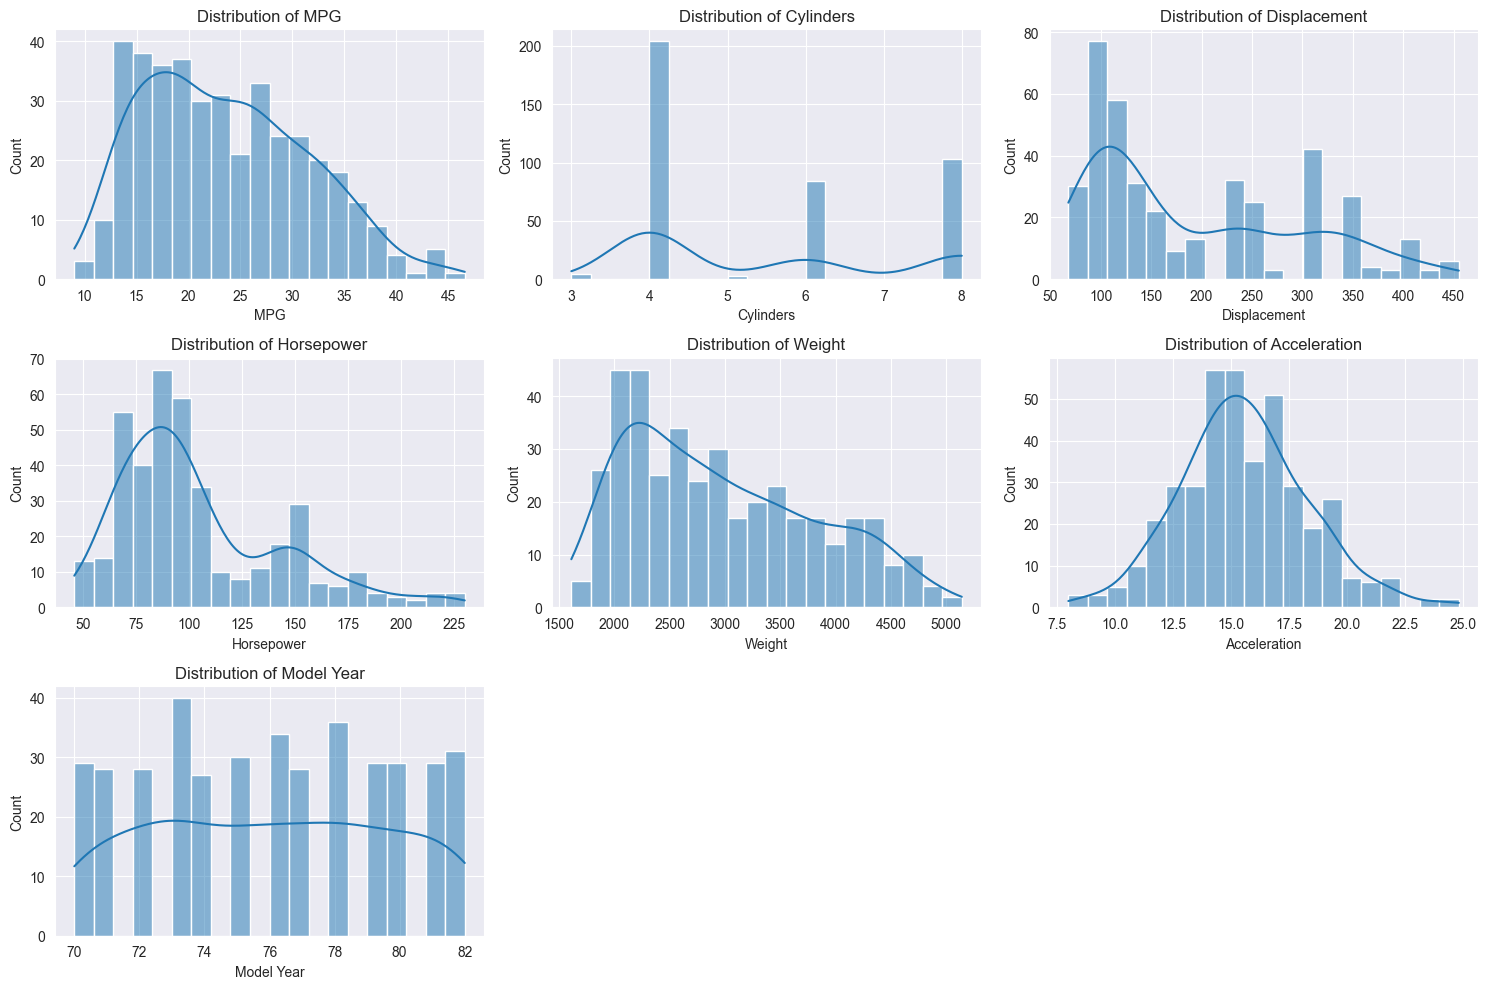

In [16]:
# Histograms for numerical features
# numerical_features = [
#     "MPG", "cylinders", "displacement", "horsepower",
#      "weight", "acceleration", "model year"
# ]
numerical_features = raw_dataset.columns[:-1]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)

    sns.histplot(dataset[feature], kde=True, bins=20 )

    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

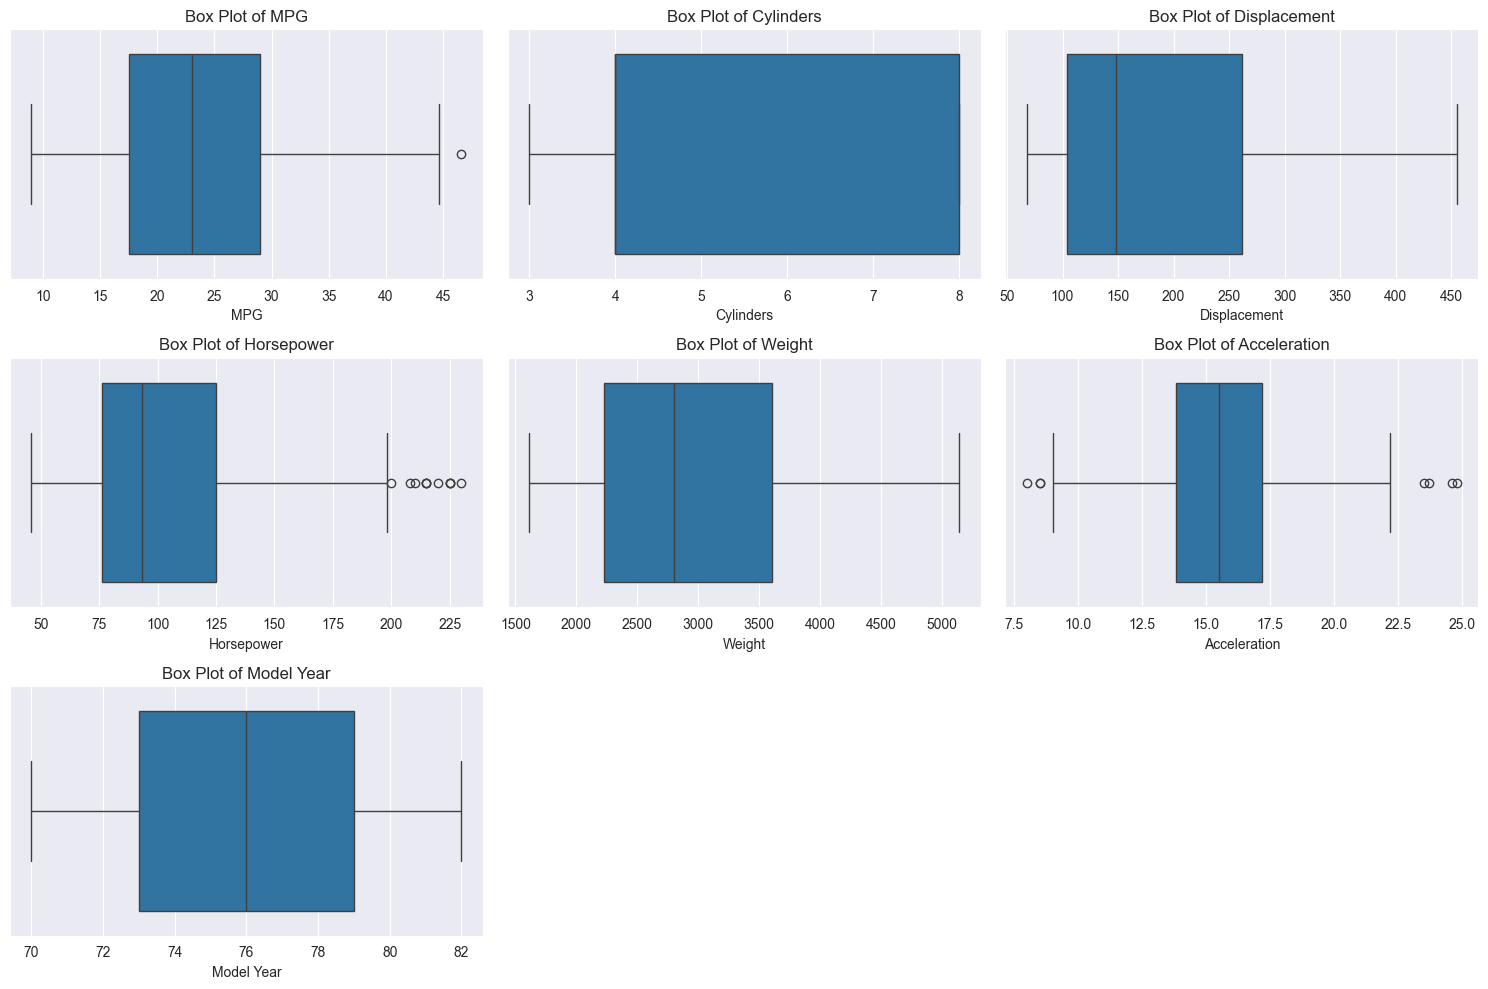

In [17]:
numerical_features = raw_dataset.columns[:-1]
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):

    plt.subplot(3, 3, i + 1)

    sns.boxplot(x=dataset[feature])

    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

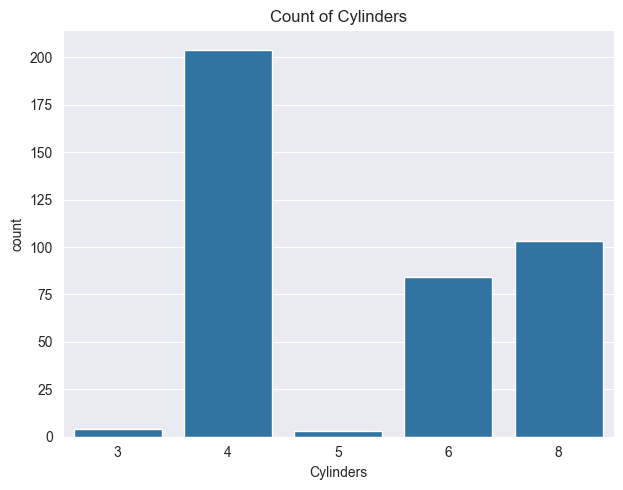

In [18]:
# Count plot for 'cylinders' and 'origin' (categorical/discrete features)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

sns.countplot(data=dataset, x='Cylinders')

plt.title('Count of Cylinders')

plt.tight_layout()
plt.show()

### 이변량 분석


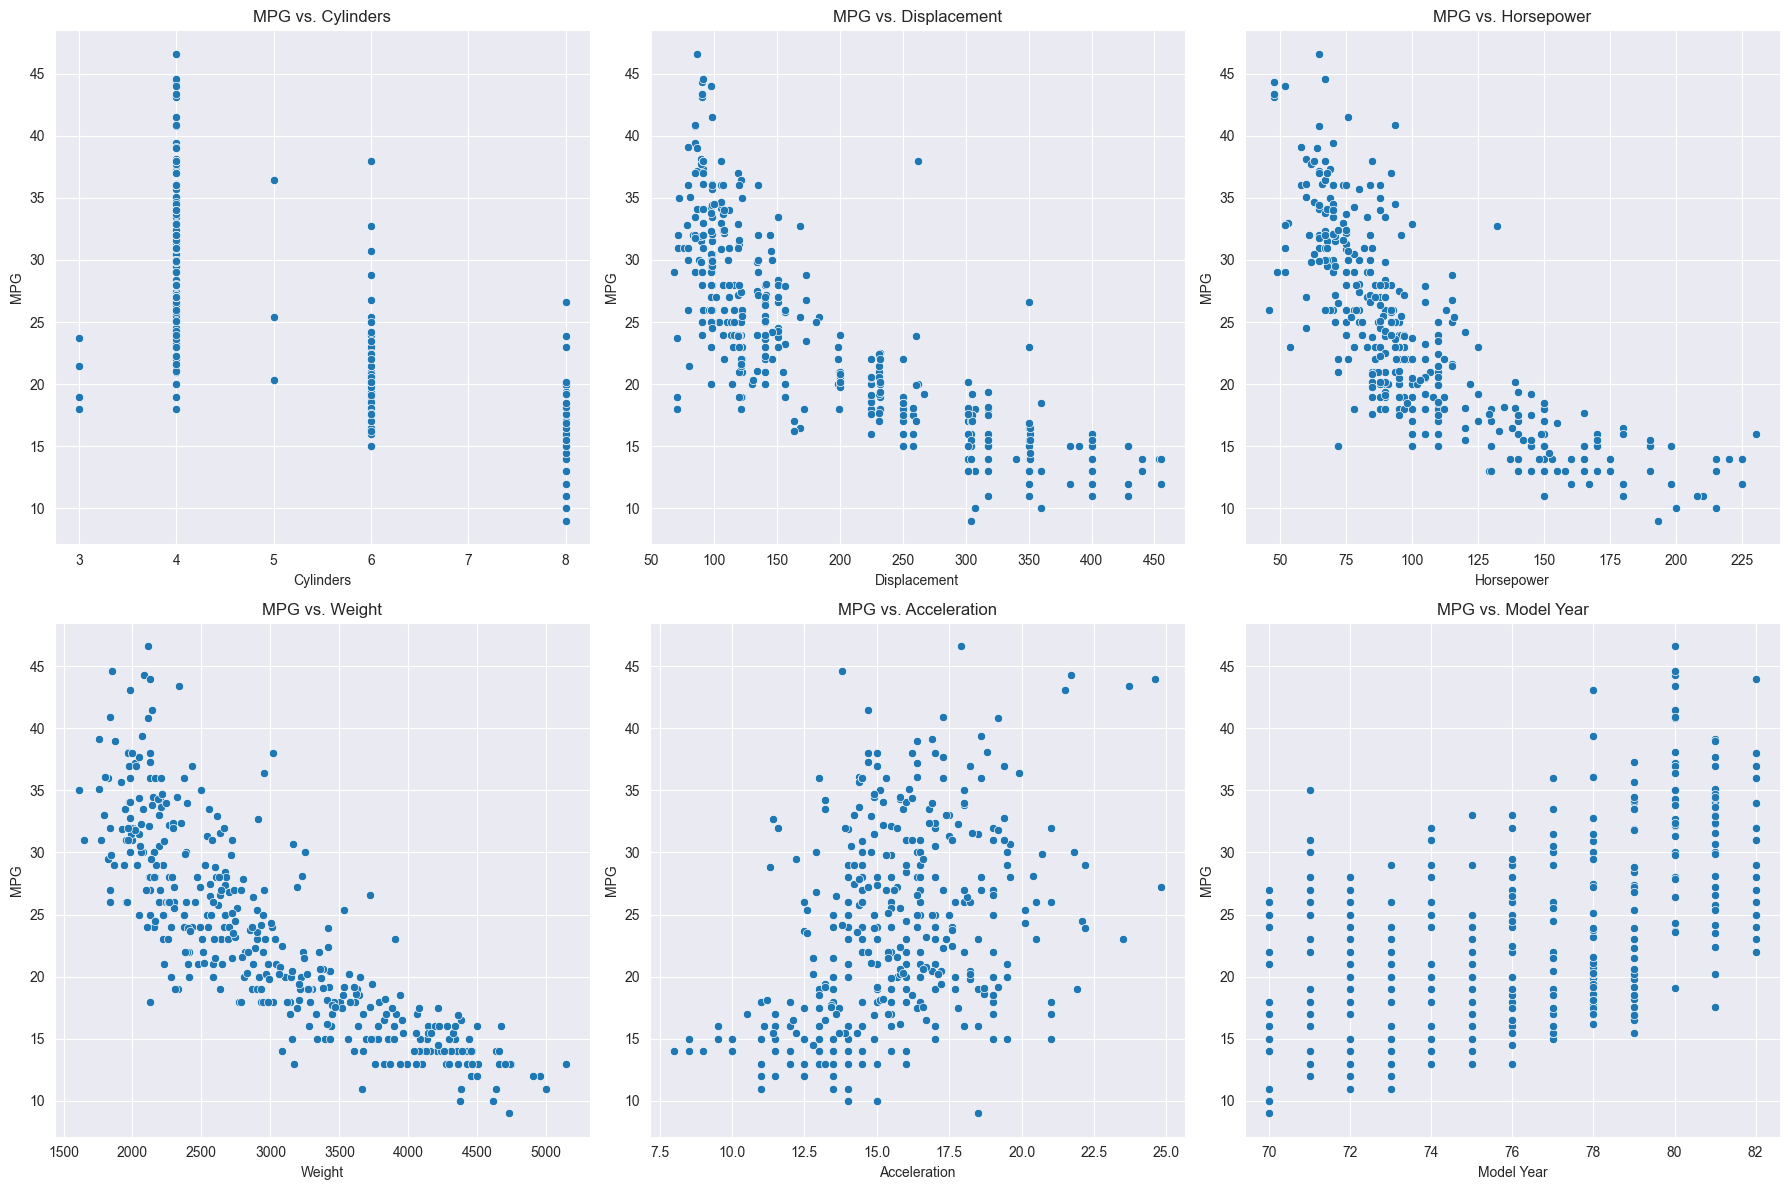

In [19]:
# MPG 대비 수치형 데이터
cols_for_scatter = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year']
plt.figure(figsize=(18, 12))
for i, feature in enumerate(cols_for_scatter):
    plt.subplot(2, 3, i + 1)

    sns.scatterplot(x=feature, y='MPG', data=dataset)

    plt.title(f'MPG vs. {feature}')
plt.tight_layout()
plt.show()

In [20]:
# Pair plot


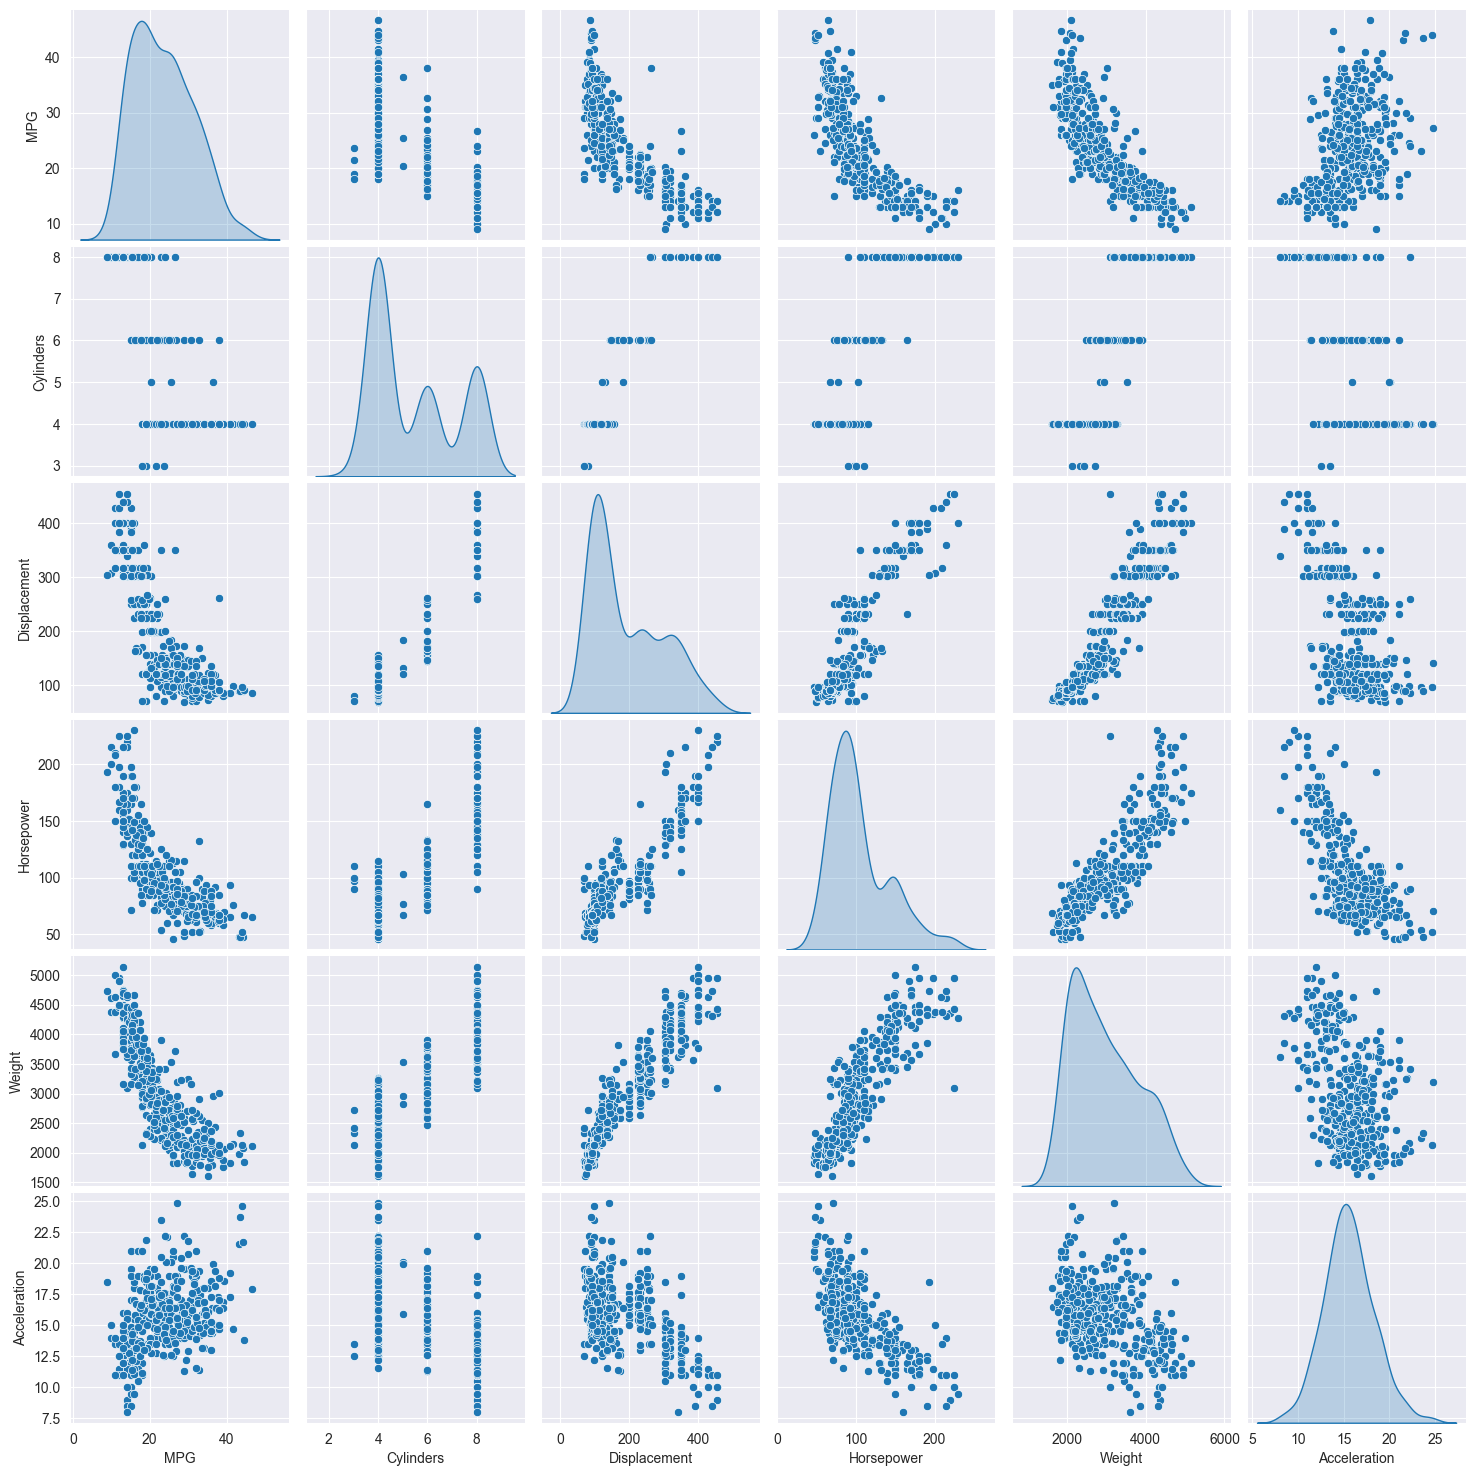

In [21]:
cols_for_paireplot = ['MPG','Cylinders', 'Displacement', 'Horsepower', 'Weight','Acceleration']

# seaborn pairplot
sns.pairplot(dataset[cols_for_paireplot], diag_kind="kde")

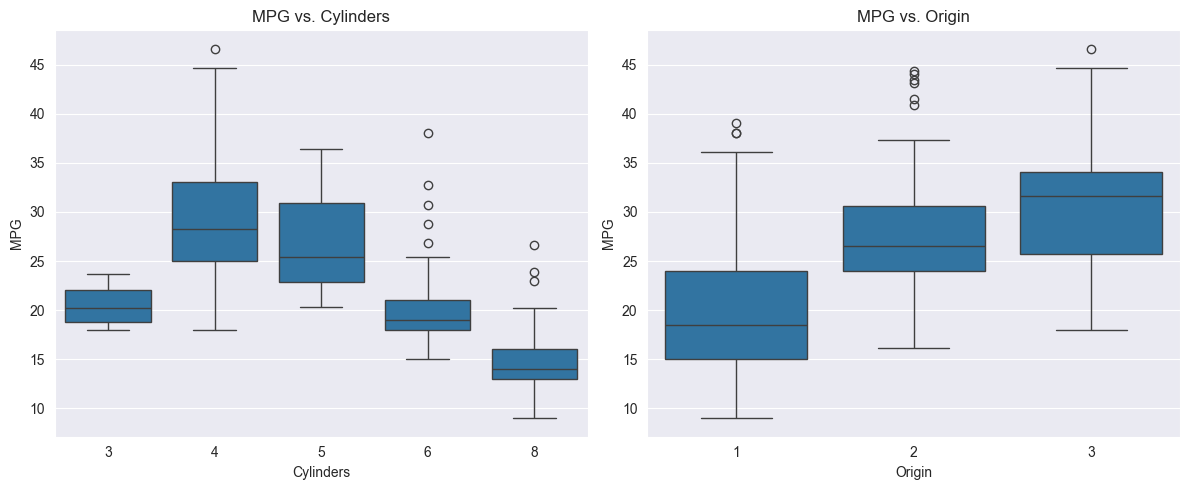

------------------------------


In [22]:
# Box plot of MPG vs. Cylinders
# Box plot of MPG vs. Origin
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Cylinders', y='MPG', data=dataset)

plt.title('MPG vs. Cylinders')

plt.subplot(1, 2, 2)
sns.boxplot(x='Origin', y='MPG', data=dataset)

plt.title('MPG vs. Origin')
plt.tight_layout()
plt.show()
print("-" * 30)

### 다변량 분석


In [23]:
dataset.head(3)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


In [24]:
# 상관계수

correlation_matrix = dataset.corr()
print("\nCorrelation Matrix:")

print(correlation_matrix)



Correlation Matrix:
                   MPG  Cylinders  Displacement  Horsepower    Weight  \
MPG           1.000000  -0.775396     -0.804203   -0.773453 -0.831741   
Cylinders    -0.775396   1.000000      0.950721    0.841284  0.896017   
Displacement -0.804203   0.950721      1.000000    0.895778  0.932824   
Horsepower   -0.773453   0.841284      0.895778    1.000000  0.862442   
Weight       -0.831741   0.896017      0.932824    0.862442  1.000000   
Acceleration  0.420289  -0.505419     -0.543684   -0.686590 -0.417457   
Model Year    0.579267  -0.348746     -0.370164   -0.413733 -0.306564   
Origin        0.563450  -0.562543     -0.609409   -0.452096 -0.581024   

              Acceleration  Model Year    Origin  
MPG               0.420289    0.579267  0.563450  
Cylinders        -0.505419   -0.348746 -0.562543  
Displacement     -0.543684   -0.370164 -0.609409  
Horsepower       -0.686590   -0.413733 -0.452096  
Weight           -0.417457   -0.306564 -0.581024  
Acceleration   

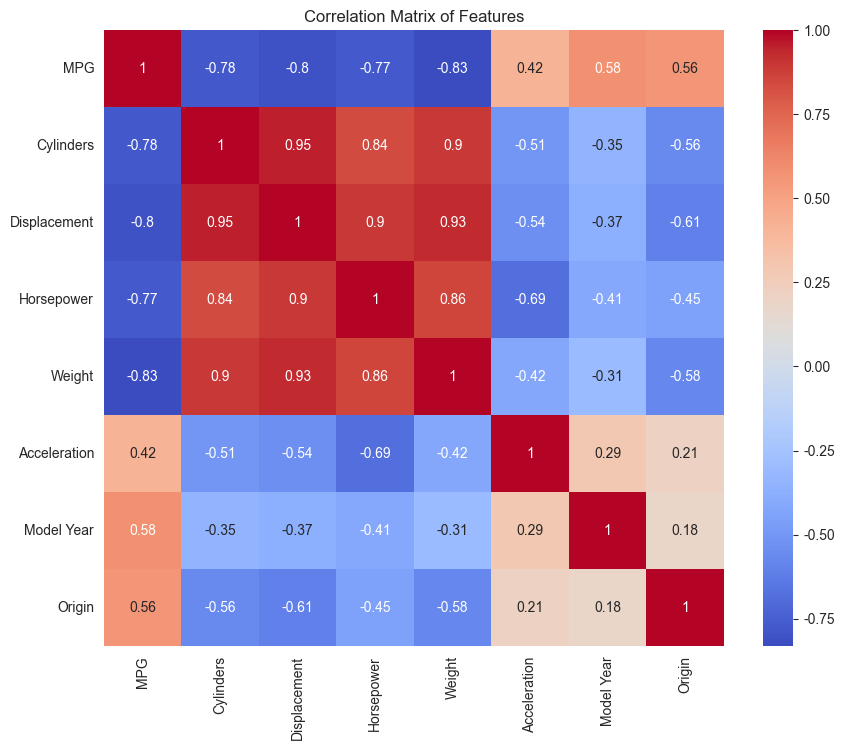

In [25]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title('Correlation Matrix of Features')
plt.show()

## 데이터셋을 훈련 세트와 테스트 세트로 분할하기



이제 데이터를 훈련 세트와 테스트 세트로 분할합니다. 테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [26]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [27]:
train_dataset.shape, test_dataset.shape

((318, 8), (80, 8))

### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [28]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.

전반적인 통계도 확인해 보죠:

In [29]:
train_stats = train_dataset.describe().T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
Horsepower,318.0,103.900943,38.391029,46.0,75.25,92.0,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
Origin,318.0,1.553459,0.799430,1.0,1.00,1.0,2.00,3.0


In [30]:
train_dataset.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Origin'],
      dtype='object')

In [31]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련합니다.

주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

In [32]:
normed_train_data.isna().sum()

Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

## 모델

### 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 `Sequential` 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다.

In [33]:
len(train_dataset.keys())

7

In [34]:
model = tf.keras.Sequential([
    keras.layers.Input((7,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

모델은 1갤런당 주행 MPG를 학습하게 된다. 결과적으로 모델의 손실함수 mse 차이 만큼의 오차를 가진 예측을 수행하게 될 것이다.

In [35]:
optimizer = keras.optimizers.RMSprop(0.0001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

### 모델 확인

`.summary` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,737 (18.50 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

모델을 한번 실행해 보죠. 훈련 세트에서 `10` 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출해 보겠습니다.

In [37]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[-0.50400686],
       [-0.04440235],
       [-0.3680588 ],
       [-0.07686079],
       [-0.22546557],
       [-0.352923  ],
       [-0.45885512],
       [-0.09992503],
       [-0.5649011 ],
       [-0.3138622 ]], dtype=float32)

In [38]:
train_labels[:10]

65     14.0
132    25.0
74     13.0
78     21.0
37     18.0
54     35.0
294    34.1
60     20.0
12     15.0
341    23.5
Name: MPG, dtype: float64

제대로 작동하는 것 같네요.

### 모델 훈련

1. `fit(callbacks=[]...)` 를 활용해 출력 내용을 조절한다
1. 모델을 1,000번의 에포크(epoch) 동안 훈련합니다. 훈련 정확도와 검증 정확도는 `history` 객체에 기록됩니다.

In [39]:
from tqdm.keras import TqdmCallback

EPOCHS = 1000

history = model.fit( normed_train_data,
                    train_labels,
                    epochs = EPOCHS,
                    validation_split = 0.2,
                    verbose=0,
                    callbacks=[TqdmCallback()])


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해 보죠.

In [40]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,6.689599,1.830638,6.689599,5.696300,1.782285,5.696300,995
996,6.674860,1.829649,6.674860,5.694655,1.783259,5.694655,996
997,6.685983,1.831434,6.685983,5.694202,1.783502,5.694202,997
998,6.685141,1.828938,6.685141,5.693460,1.781567,5.693460,998
999,6.689706,1.830503,6.689706,5.692425,1.782433,5.692425,999


Epoch 동안 MSE 와 MSE^2

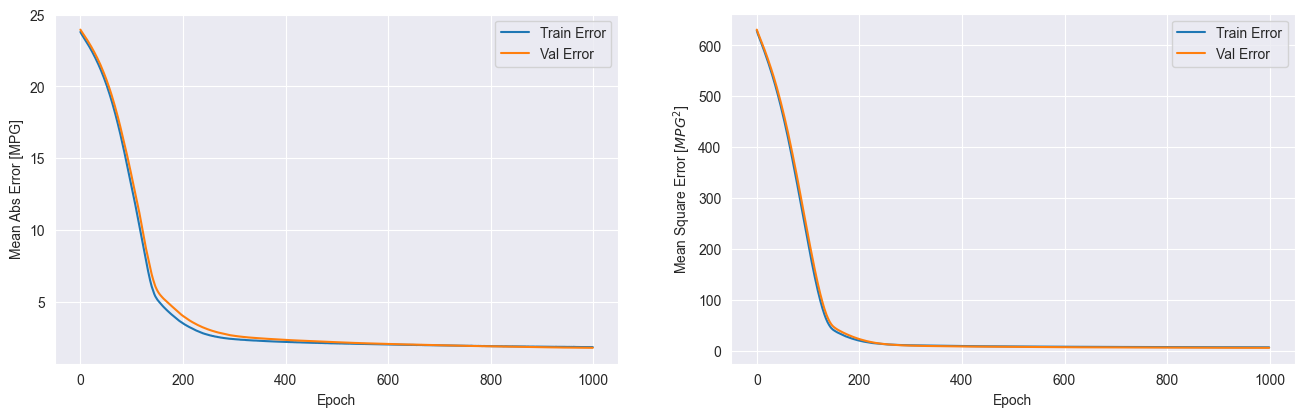

In [41]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,10))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    # plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. `model.fit` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 에포크마다 훈련 상태를 점검하기 위해 *EarlyStopping 콜백(callback)*을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

## Earlystopping

In [42]:
model2 = tf.keras.Sequential([
    keras.layers.Input((7,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])


model2.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

In [43]:
from tqdm.keras import TqdmCallback

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# optimizer = keras.optimizers.RMSprop(0.001)
optimizer = keras.optimizers.RMSprop(0.0001)

history = model2.fit( normed_train_data,
                    train_labels,
                    epochs = EPOCHS,
                    validation_split = 0.2,
                    verbose=0,
                    callbacks=[early_stop, TqdmCallback()])
plot_history(history)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

NotImplementedError: numpy() is only available when eager execution is enabled.

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

In [ ]:
loss, mae, mse = model2.evaluate(normed_test_data, test_labels)

print("테스트 세트 MAE: {:5.2f} MPG".format(mae))
print("테스트 세트 MSE: {:5.2f} MPG".format(mse))

## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

In [ ]:

test_predictions = model2.predict(normed_test_data).flatten()
test_predictions.shape

In [ ]:
# Plotting test predictions (True MPG vs Predicted MPG)

test_predictions = model2.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)

plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.legend()
plt.show()

모델이 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴 보죠.

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)

plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

## 정리

회귀 학습시

* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다
* 회귀에서 사용되는 평가 지표는 평균 절댓값 오차(MAE)입니다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.